In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

In [2]:
fname = '../../data/analysis/power_simulation.n_sig.30_reps.txt'

df = pd.read_csv(fname, sep='\t')
df.head()

,alpha,n_sig_allsamples,taxa_level,n_sig,n_ctrl,n_case,total_n,perc_case,study,rep
0,0.05,1452,otu,0,9,1,10,0.10,cdi_schubert,0
1,0.05,1452,otu,0,8,3,10,0.25,cdi_schubert,0
2,0.05,1452,otu,0,5,5,10,0.50,cdi_schubert,0
3,0.05,1452,otu,0,3,8,10,0.75,cdi_schubert,0
4,0.05,1452,otu,262,1,9,10,0.90,cdi_schubert,0


In [3]:
df['perc_sig'] = df['n_sig'] / df['n_sig_allsamples']

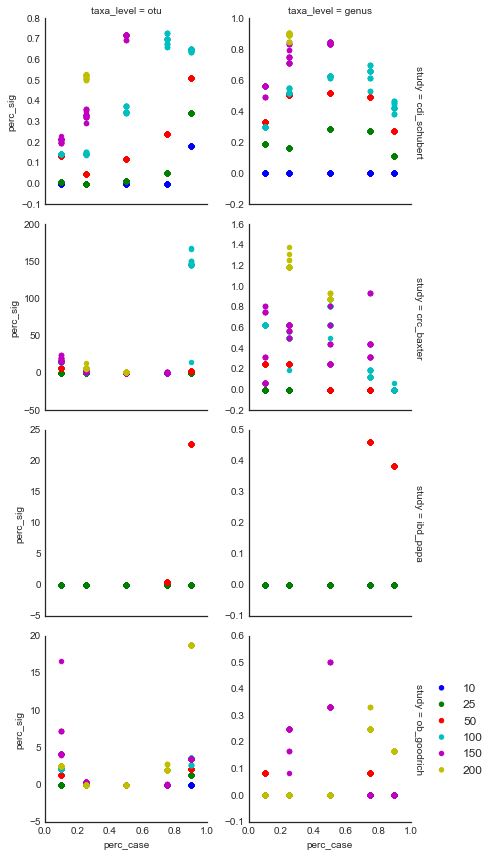

In [4]:
g = sns.FacetGrid(col='taxa_level', row='study', 
                  data=df.query('alpha == 0.05'), hue='total_n', 
                  sharey=False, margin_titles=True)
g.map(plt.scatter, 'perc_case', 'perc_sig')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

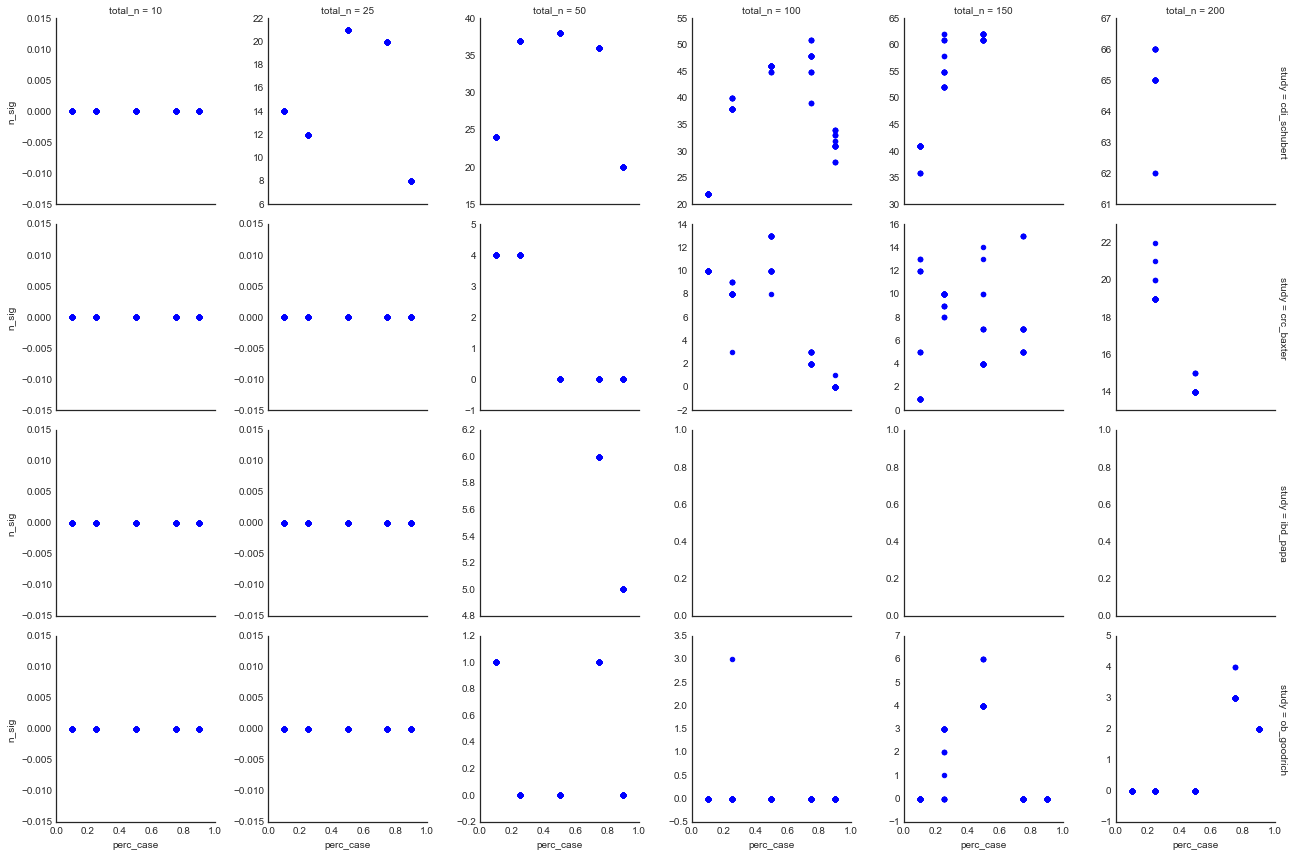

In [5]:
g = sns.FacetGrid(col='total_n', row='study', 
                  data=df.query('alpha == 0.05').query('taxa_level == "genus"'),
                  sharey=False, margin_titles=True)
g.map(plt.scatter, 'perc_case', 'n_sig')#, jitter=True)


Same plot, but with the axes ordered like Rafa suggested.

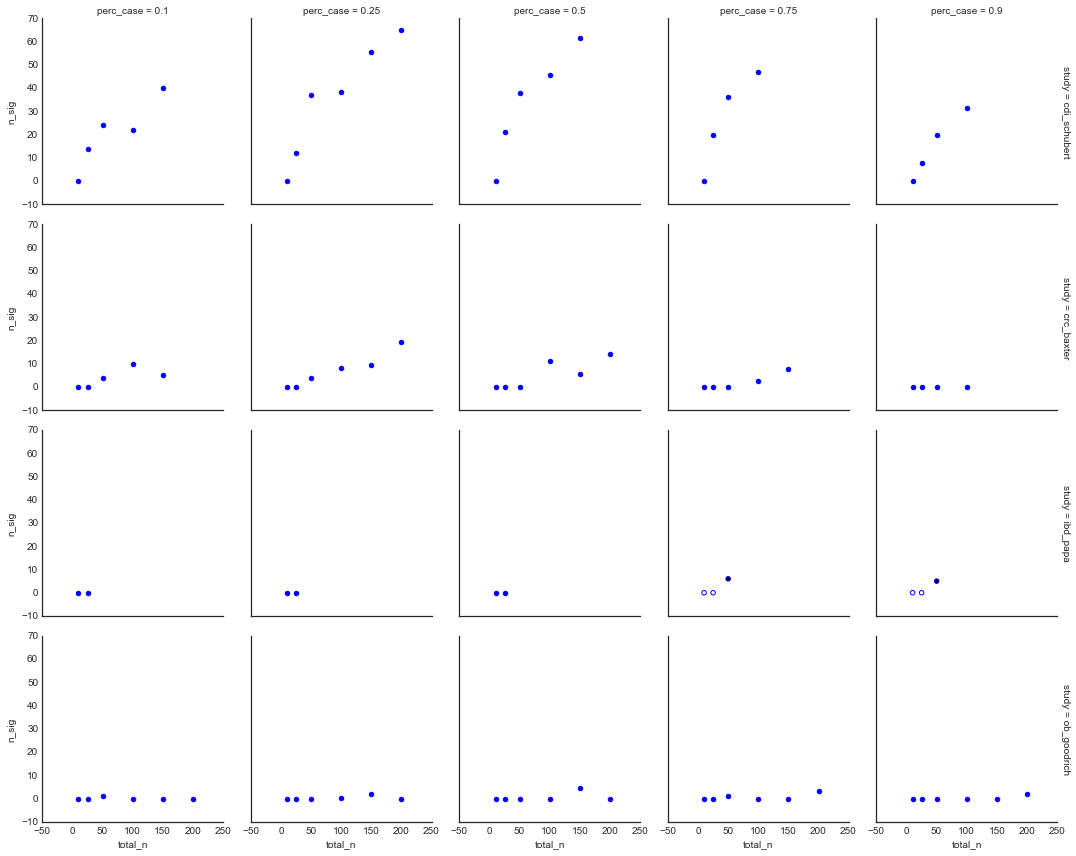

In [12]:
mean_sig = (
    df.query('alpha == 0.05')
      .query('taxa_level == "genus"')
      .groupby(['study', 'total_n', 'perc_case'])
      .mean()
      .reset_index()
    )
g = sns.FacetGrid(col='perc_case', row='study', 
                  data=mean_sig, 
                  sharey=True, margin_titles=True)
g.map(plt.scatter, 'total_n', 'n_sig')#, jitter=True)


How many genera do I expect per plot?

In [13]:
def make_sig_plot(data, n_total, ycol):
    """
    data : pandas DataFrame
        'perc_case' is the x-axis, ycol is the y-axis
        'total_n' is the subplots
    """
    
    g = sns.FacetGrid(col='perc_case', data=data)
    g.map(plt.scatter, 'total_n', ycol)
    
    # Annotate the axes
    for ax in g.axes.flatten():
        ax.axhline(n_total, linestyle='--')
        
        if ycol == "n_sig":
            ax.set_ylim([-1, None])
        else:
            ax.set_ylim([-0.01, None])
        ax.set_title(ax.get_title().split('=')[1])
        

## Genus-level

cdi_schubert
73.0
crc_baxter
16.0
ibd_papa
13.0
ob_goodrich
12.0


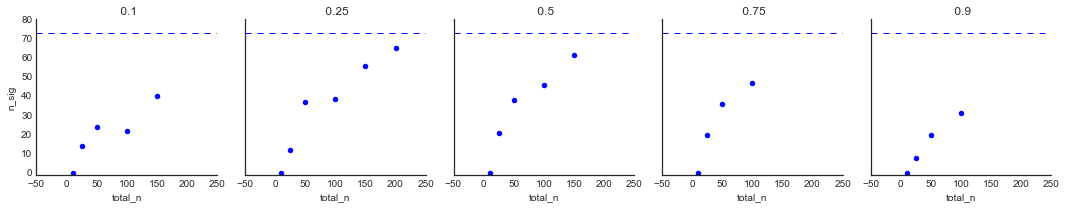

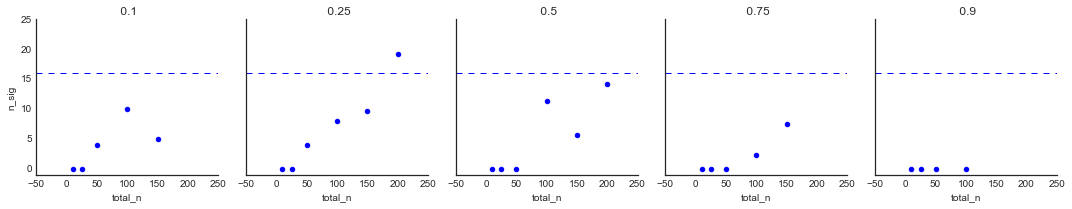

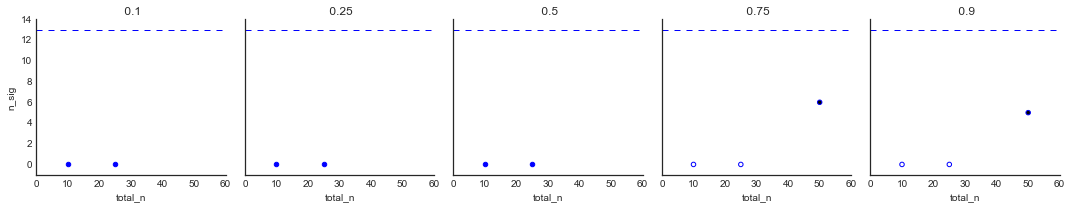

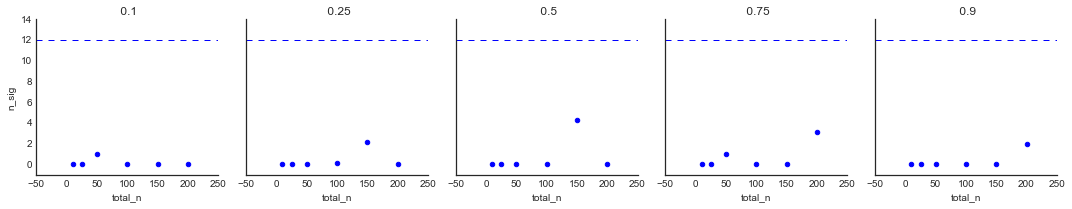

In [17]:
alpha = 0.05
tax_level = 'genus'

for dataset, subdf in mean_sig.groupby('study'):
    print(dataset)
    #data = subdf.query('alpha == @alpha').query('taxa_level == @tax_level')
    data = subdf
    total_n = data['n_sig_allsamples'].unique()
    if len(total_n) > 1:
        print('Oops more than one "total n_sig"')
    total_n = total_n[0]
    print(total_n)
    make_sig_plot(data, total_n, 'n_sig')

cdi_schubert
73
crc_baxter
16
ibd_papa
13
ob_goodrich
12


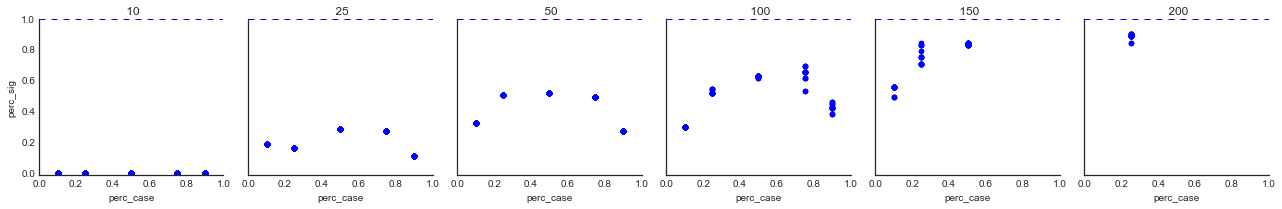

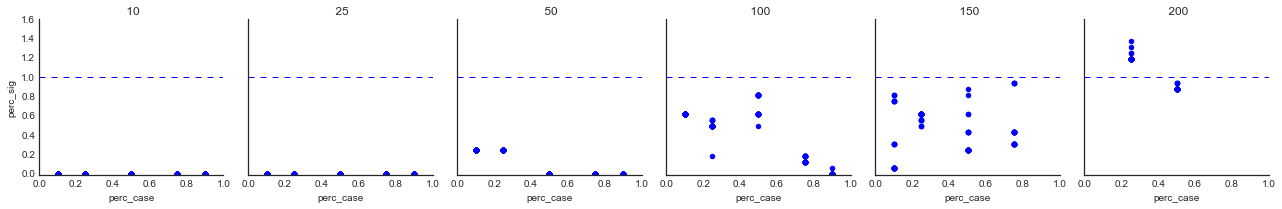

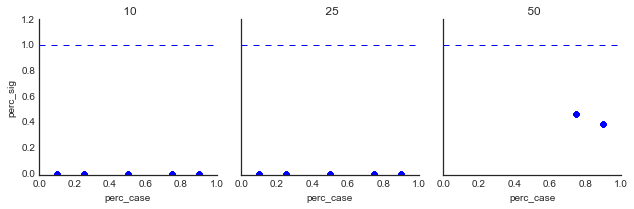

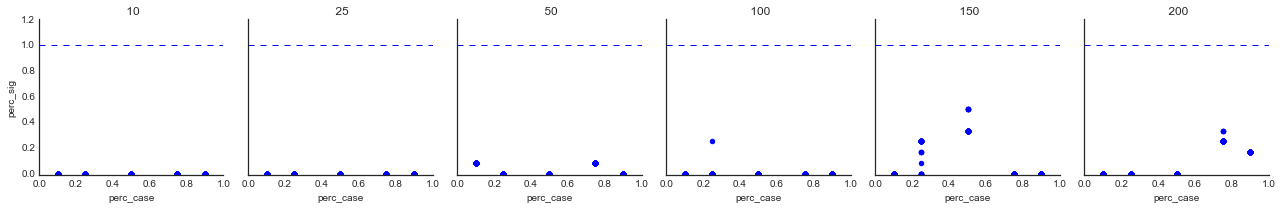

In [8]:
alpha = 0.05
tax_level = 'genus'

for dataset, subdf in df.groupby('study'):
    print(dataset)
    data = subdf.query('alpha == @alpha').query('taxa_level == @tax_level')
    total_n = data['n_sig_allsamples'].unique()
    if len(total_n) > 1:
        print('Oops more than one "total n_sig"')
    total_n = total_n[0]
    print(total_n)
    make_sig_plot(data, 1.0, 'perc_sig')

## OTU-level

cdi_schubert
1452
crc_baxter
7
ibd_papa
12
ob_goodrich
75


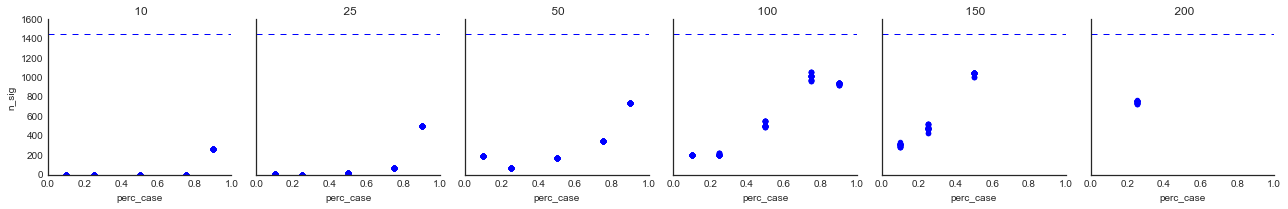

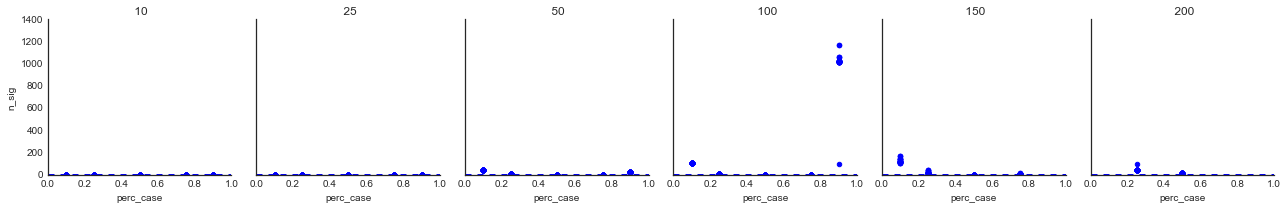

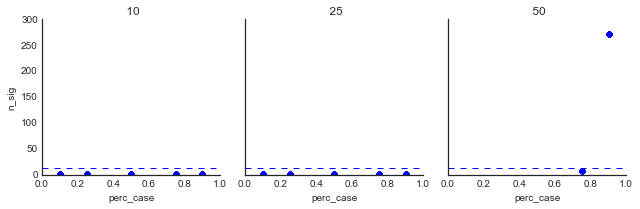

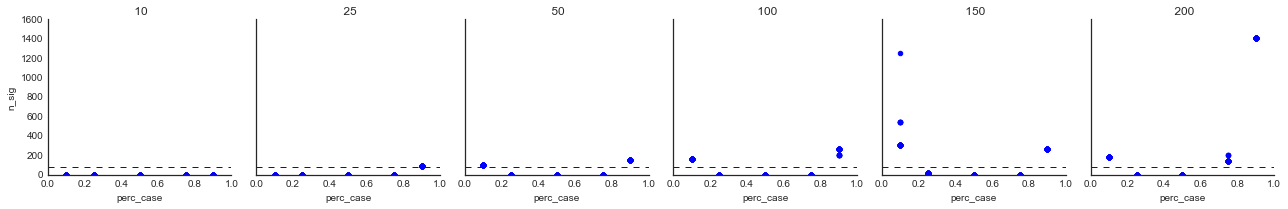

In [9]:
alpha = 0.05
tax_level = 'otu'

for dataset, subdf in df.groupby('study'):
    print(dataset)
    data = subdf.query('alpha == @alpha').query('taxa_level == @tax_level')
    total_n = data['n_sig_allsamples'].unique()
    if len(total_n) > 1:
        print('Oops more than one "total n_sig"')
    total_n = total_n[0]
    print(total_n)
    make_sig_plot(data, total_n, 'n_sig')

# Which OTUs are getting picked up?

If I'm developing a therapeutic, I really only care about picking up "the most important" OTUs. So rather than focusing on percentage of total OTUs, I should look at number out of the top 10 (or something).

In [10]:
fname = '../../data/analysis/power_simulation.otu_qvalues.txt'

fullres = pd.read_csv(fname, sep='\t')
fullres.shape

IOError: File ../../data/analysis/power_simulation.otu_qvalues.txt does not exist

In [ ]:
fullres.head()

So I have a column called `q_allsamples` - let's use this to label the "top" OTUs in each study, and then look at what percent of the top 10 OTUs in each study are found in each simulation. I can also look at correlation between rank in simulation and rank in full dataset.

In [ ]:
new_fullres = []
for g, subdf in fullres.groupby(['study', 'taxa_level']):
    tmp = subdf[['otu', 'q_allsamples']].drop_duplicates()
    # Rank OTUs
    tmp = tmp.sort_values(by='q_allsamples')
    tmp['otu_sig_rank'] = range(1, len(tmp) + 1)
    # Add dataset for re-merging
    tmp['study'] = g[0]
    # Merge on common columns ('study', 'otu', and 'q_allsamples')
    tmp = pd.merge(subdf, tmp)
    new_fullres.append(tmp)

In [ ]:
pd.concat(new_fullres).shape

In [ ]:
fullres = pd.concat(new_fullres)
fullres.head()

Now, calculate the % of top 10 OTUs in each study/perc_case/total_n combo (for alpha = 0.05)

In [ ]:
# This will be the general format of the results
df.head()

In [ ]:
n_top_hits = [3, 5, 10]

perc_res_lst = []
for g, subdf in fullres.groupby(['study', 'taxa_level', 'rep', 'total_n', 'perc_case']):
    for n in n_top_hits:
        # Get the number of "top" OTUs which are significant
        n_sig = subdf.query('otu_sig_rank <= @n').query('q < 0.05').shape[0]
        perc_res_lst.append(list(g) + [n, n_sig])

In [ ]:
perc_res = pd.DataFrame(data=perc_res_lst,
                        columns=['study', 'taxa_level', 'rep', 'total_n', 'perc_case', 'number_of_top_hits', 'n_sig'])

Okay, let's plot now...

In [ ]:
g = sns.FacetGrid(col='total_n', row='study', hue='number_of_top_hits', 
                  data=perc_res.query('taxa_level == "genus"'),
                  margin_titles=True)
g.map(plt.scatter, 'perc_case', 'n_sig')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

#for ax in g.axes.flatten():
#    ax.axhline(10, color='red', linestyle='--', alpha=0.5)
#    ax.axhline(5, color='green', linestyle='--', alpha=0.5)
#    ax.axhline(3, color='blue', linestyle='--', alpha=0.5)

In [ ]:
perc_res['perc_top_hits_sig'] = perc_res['n_sig'] / perc_res['number_of_top_hits']

In [ ]:
g = sns.FacetGrid(col='total_n', row='study', hue='number_of_top_hits', 
                  data=perc_res.query('taxa_level == "genus"'))
g.map(plt.scatter, 'perc_case', 'perc_top_hits_sig')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

Ugh, just plot the means!